-----------------------------------------

# **_Tutorial I : Compute the pulsar phases of the events_**

-----

The first step for the pulsar analysis, once the DL2 or DL3 files are created, is to add the phases to the different files. To add the phases we use the package PINT-pulsar (https://nanograv-pint.readthedocs.io/en/latest/). We need two basic ingredients:

- The times of arrivals (i.e. the DL2 or DL3 files)
- The model of the rotation of the pulsar, also known as ephemeris of the pulsar. This can be given with a file in .par format or .gro format. The .par ephemeris format is the same used in other softwares such as TEMPO2

To simplify this step, we created two scripts to add the phases to the files in the ptiming_ana.cphase module:

- add_DL3_phase_table.py
- add_DL2_phase_table.py

Let's see how these scripts work.

-----

In [1]:
import numpy as np
import pandas as pd
from astropy.io import fits
from lstchain.io.io import dl2_params_lstcam_key
import matplotlib.pyplot as plt
import time
from ptiming_ana.cphase import DL3_calphase

In [2]:
import astropy
import pandas
import pint
import lstchain

print(f'astropy version: {astropy.__version__}')
print(f'lstchain version: {lstchain.__version__}')
print(f'pandas version: {pandas.__version__}')
print(f'PINT-pulsar version: {pint.__version__}')

astropy version: 5.3.2
lstchain version: 0.10.6
pandas version: 2.0.3
PINT-pulsar version: 0.9.7


In [10]:
# workspace_dir = '/home/francesco.schiavone/lst-analysis-school-2024/school-repo/pulsar' #Change this to your working directory
workspace_dir = './'

## **1. Checking the files**

### **1.1 DL3 files**

For the DL3 files one should already have applied the cuts on the reconstructed parameters and the IRF should be included (see lstchain tools). When we apply the scripts the format of the DL3 files will now change. 

The time information in the files should be correct, if it is not, it should be corrected before applying the script.

In [4]:
DL3_file = '/fefs/aswg/workspace/analysis-school-2024/pulsar/Notebook1/Geminga/DL3/dl3_LST-1.Run11533.fits'

orig_table = fits.open(DL3_file)[1]

In [5]:
df = pd.DataFrame(orig_table.data)
df_sorted = df.sort_values('TIME')

In [6]:
df_sorted

,EVENT_ID,TIME,RA,DEC,ENERGY,GAMMANESS,MULTIP,GLON,GLAT,ALT,AZ
0,43,1.332400e+08,99.324742,17.773958,0.063758,0.723776,1,195.499210,4.987755,69.414689,241.831649
1,55,1.332400e+08,99.324742,17.773958,0.025620,0.802843,1,195.499210,4.987755,69.414685,241.831657
2,74,1.332400e+08,99.324742,17.773958,0.036872,0.858042,1,195.499210,4.987755,69.414678,241.831671
3,80,1.332400e+08,99.324742,17.773958,0.022855,0.783683,1,195.499210,4.987755,69.414675,241.831676
4,258,1.332400e+08,99.324741,17.773958,0.088195,0.766138,1,195.499209,4.987755,69.414602,241.831829
...,...,...,...,...,...,...,...,...,...,...,...
126135,8758330,1.332412e+08,99.327792,17.773994,0.026644,0.753655,1,195.500497,4.990361,65.458656,248.616623
254158,8758331,1.332412e+08,98.475638,17.770253,0.051455,0.936600,1,195.133845,4.265814,64.759874,249.596944
126136,8758363,1.332412e+08,99.327793,17.773993,0.078663,0.676499,1,195.500498,4.990362,65.458641,248.616642
126137,8758396,1.332412e+08,99.327794,17.773992,0.039448,0.633338,1,195.500499,4.990362,65.458624,248.616665


### **1.2 Ephemeris**

The ephemeris should be in .par format (or exceptionally in .gro format, typically used for the Crab pulsar). Let's see a .par file for the Geminga pulsar:

In [7]:
parfile = '/fefs/aswg/workspace/analysis-school-2024/pulsar/Notebook1/Geminga/J0633+1746_latest.par'

In [8]:
!cat {parfile}

# Created: 2023-03-23T11:00:14.568627
# PINT_version: 0.9.3
# User: ceribell
# Host: magicserv01
# OS: Linux-5.4.0-135-generic-x86_64-with-glibc2.27
# Format: tempo2
MODE        1
PSRJ        J0633+1746
EPHEM        DE421
CLK        TT(BIPM2021)
UNITS        TDB
START        54685.2708194922670373
FINISH        60022.9529084122696077
DILATEFREQ        N
DMDATA        0
NTOA        976
RAJ        6:33:54.27084820        1        0.00064399147036503848
DECJ        17:46:14.70788530        1        0.08663753424655418200
PMRA        142.2        0        1.1
PMDEC        107.4        0        1.2
PX        4.0        0        1.3
POSEPOCH        54800.0000000000000000
F0        4.217568150994043918445e+00        1        1.0749252556937584317e-12
F1        -1.951677094087304865317e-13        1        7.8016522586842728266e-21
F2        -1.139680387377339574538e-23        1        1.850394396670102159e-28
PEPOCH        54735.6262945038033649
TZRMJD        54735.626293909153901
TZRSITE     



A description of the main parameters:

----------------

- PSR: name of the pulsar
- EPHEM: solar system ephemeris to be used (typically DE200 or DE421)

-----------
- START: starting time of the validity of the model
- FINISH: end time of the validity of the model

**It is very important to check that the epoch of the observation of each DL3 file is between START and FINISH. Sometimes we need to apply different models for different files.**

-----------
- F0/F1/F2: frequency of the pulsar and its first and second derivative
- PEPOCH: epoch for the reference phase
- TZRMJD: time for the reference phase (related to the phase0)
- PLANET_SHAPIRO: set to Y if we want to include the planets in the Shapiro correction


## **2. Applying correction to the DL3 files (standard)**

### **2.1. Using the internal functions of cphase**

Now let's apply the correction to the DL3 files. This is done with a function defined in cphase. First let's see how the function works:

In [9]:
?DL3_calphase

Signature:
DL3_calphase(
    file,
    ephem,
    output_dir,
    create_tim_file=False,
    obs='lst',
    use_interpolation=False,
    n_interp=1000,
    pickle=False,
)
Docstring:
Function that reads the DL3 files, calculates the phases and create a new DL3 file. The new DL3 file will have two new columns: 'PHASE' and 'BAYCENT_TIME'.

Parameters:
------------------
file: string 
path to the DL3 file in a .fits format

ephem: string
path to the ephemeris file. It can be a .par file or a .gro file (for the case of Crab)

output_dir: string
path to the output directory where to store the modified DL3 file

pickle: boolean
True if want to save a pickle file with the loaded TOAs

create_tim_file: boolean
Set to True if want to create and save a .tim file

use_interpolation: boolean
Set to True if want to use the interpolation method (faster but loses some precision)

n_interp: int
Number of events between two interpolation points.

Returns:
-------------------------
A new DL3 file with t

----

As one can see there are multiple parameters with different options. Only three are generally needed:

- file : DL3 file to analyze
- ephem_file: Ephemeris to use
- ouput_dir: output directory where to store the DL3 pulsar file

The rest are all optional. Alhough an interpolation is also available this is generally more used at DL2 level. Let's set the params:

In [11]:
file = '/fefs/aswg/workspace/analysis-school-2024/pulsar/Notebook1/Geminga/DL3/dl3_LST-1.Run11533.fits' #file to compute corrections
ephem_file = '/fefs/aswg/workspace/analysis-school-2024/pulsar/Notebook1/Geminga/J0633+1746_latest.par' #ephemeris to use
output_dir = workspace_dir+'output/DL3_pulsar_Geminga/' #Output directory where to store the DL3 pulsar files (different from the DL3 directory!)

And let's execute the function:

In [12]:
DL3_calphase(file, ephem=ephem_file, output_dir = output_dir)

2024-02-21 11:56:49 INFO   [ptiming_ana.cphase.pulsarphase_cal] Setting the .par file
2024-02-21 11:58:17.787 | DEBUG    | pint.toa:__init__:1350 - No pulse number flags found in the TOAs
2024-02-21 11:58:18.358 | DEBUG    | pint.toa:apply_clock_corrections:2192 - Applying clock corrections (include_gps = True, include_bipm = True)
2024-02-21 11:58:38.039 | INFO     | pint.observatory:gps_correction:209 - Applying GPS to UTC clock correction (~few nanoseconds)
2024-02-21 11:58:38.044 | INFO     | pint.observatory:_load_gps_clock:92 - Loading global GPS clock file
2024-02-21 11:58:38.088 | INFO     | pint.observatory.global_clock_corrections:get_file:128 - File index.txt to be downloaded due to download policy if_expired: https://raw.githubusercontent.com/ipta/pulsar-clock-corrections/main/index.txt
2024-02-21 11:58:38.697 | DEBUG    | pint.observatory.clock_file:__init__:799 - Global clock file gps2utc.clk saving kwargs={'bogus_last_correction': False, 'valid_beyond_ends': False}
2024-

This will create a new file called {_DL3_file_name_}_pulsar.fits in the output_dir directory. 

In [13]:
!ls $output_dir

dl3_LST-1.Run11533_pulsar.fits


Since it takes some time to run (~5min) I have copied the output file in /fefs/aswg/workspace/analysis-school-2024/pulsar/Notebook1/Geminga/DL3/

In [14]:
ls /fefs/aswg/workspace/analysis-school-2024/pulsar/Notebook1/Geminga/DL3/

dl3_LST-1.Run11533.fits  dl3_LST-1.Run11533_pulsar.fits


### **2.2. Using the script on the terminal (recommended way)**

Alternatively, one can use the script add_DL3_phase table in the terminal, which inside calls to this function. This is the easiest way to go. Let's see first the info about the script

In [15]:
!add_DL3_phase_table --help

usage: add_DL3_phase_table [-h] [--dir DIRECTORY] [--in-file IN_FILE]
                           [--ephem EPHEM] [--output DIR_OUTPUT]
                           [--pickle PICKLE] [--run-number RUN]
                           [--number-interpolation NINTERP]
                           [--observatory OBSERVATORY] [--interpolation]
                           [--create-tim]

optional arguments:
  -h, --help            show this help message and exit
  --dir DIRECTORY, -d DIRECTORY
                        Directory where to find the DL3 files
  --in-file IN_FILE, -f IN_FILE
                        DL3 standard file if want to analyze only one file
  --ephem EPHEM, -ephem EPHEM
                        Path to the ephemeris file (.par or .gro)
  --output DIR_OUTPUT, -out DIR_OUTPUT
                        Path where to store the DL3 file with the pulsar info
  --pickle PICKLE, -pickle PICKLE
                        Set True to pickle
  --run-number RUN, -r RUN
                        Run num

Now we can execute the script with the three main arguments: file, ephem and output

In [12]:
!add_DL3_phase_table --in-file=$file --ephem=$ephem_file --output=$output_dir

2024-02-09 11:04:48 INFO   [ptiming_ana.cphase.pulsarphase_cal] Setting the .par file
^C
Traceback (most recent call last):
  File "/fefs/aswg/software/conda/envs/lst-school-2024-02-pulsar-analysis/bin/add_DL3_phase_table", line 8, in <module>
    sys.exit(main())
  File "/fefs/aswg/software/virtual_env/ctasoft/PulsarTimingAnalysis/ptiming_ana/cphase/add_DL3_phase_table.py", line 116, in main
    DL3_calphase(in_file,ephem,output_dir,create_tim,observatory,interpolation,ninterp,pickle)
  File "/fefs/aswg/software/virtual_env/ctasoft/PulsarTimingAnalysis/ptiming_ana/cphase/pulsarphase_cal.py", line 285, in DL3_calphase
    barycent_toas, phases = compute_phases_from_times_model(times, model)
  File "/fefs/aswg/software/virtual_env/ctasoft/PulsarTimingAnalysis/ptiming_ana/cphase/pulsarphase_cal.py", line 358, in compute_phases_from_times_model
    toa_list = list(toa.TOA(t, 0, obs=obs, ephem='DE421', include_bipm=str(include_bipm),
  File "/fefs/aswg/software/virtual_env/ctasoft/PulsarTi

**Note: it will overwrite the current DL3 pulsar file**

If one wants to execute the code for all the files in a directory one can use the --dir argument. Nonetheless, most of the times we run jobs in parallel so it is faster to such run one job for each file in the directory using the previous command. 

However, we can still use this parameter, and the --run parameter to execute the code for one specific run in the directory.

In [56]:
DL3_dir = '/fefs/aswg/workspace/analysis-school-2024/pulsar/Notebook1/Geminga/DL3/'

!add_DL3_phase_table --dir=$DL3_dir --ephem=$ephem_file --run-number 11533 --output=$output_dir

2024-01-29 14:02:49 INFO   [ptiming_ana.cphase.pulsarphase_cal] Setting the .par file
2024-01-29 14:04:11.545 | DEBUG    | pint.toa:__init__:1350 - No pulse number flags found in the TOAs
2024-01-29 14:04:12.088 | DEBUG    | pint.toa:apply_clock_corrections:2192 - Applying clock corrections (include_gps = True, include_bipm = True)
2024-01-29 14:04:30.549 | INFO     | pint.observatory:gps_correction:209 - Applying GPS to UTC clock correction (~few nanoseconds)
2024-01-29 14:04:30.551 | INFO     | pint.observatory:_load_gps_clock:92 - Loading global GPS clock file
2024-01-29 14:04:30.562 | DEBUG    | pint.observatory.clock_file:__init__:799 - Global clock file gps2utc.clk saving kwargs={'bogus_last_correction': False, 'valid_beyond_ends': False}
2024-01-29 14:04:30.565 | DEBUG    | pint.observatory.clock_file:read_tempo2_clock_file:456 - Loading TEMPO2-format observatory clock correction file gps2utc.clk (/home/alvaro.mas/.astropy/cache/download/url/d3c81b5766f4bfb84e65504c8a453085/cont

Which will give us the same result.

### **2.3 Exploring the DL3 pulsar files**

Let's explore this new pulsar file and compare it with the original one:

In [16]:
pulsar_file = '/fefs/aswg/workspace/analysis-school-2024/pulsar/Notebook1/Geminga/DL3/dl3_LST-1.Run11533_pulsar.fits'
pulsar_table = fits.open(pulsar_file)[1]

In [17]:
df_sorted

,EVENT_ID,TIME,RA,DEC,ENERGY,GAMMANESS,MULTIP,GLON,GLAT,ALT,AZ
0,43,1.332400e+08,99.324742,17.773958,0.063758,0.723776,1,195.499210,4.987755,69.414689,241.831649
1,55,1.332400e+08,99.324742,17.773958,0.025620,0.802843,1,195.499210,4.987755,69.414685,241.831657
2,74,1.332400e+08,99.324742,17.773958,0.036872,0.858042,1,195.499210,4.987755,69.414678,241.831671
3,80,1.332400e+08,99.324742,17.773958,0.022855,0.783683,1,195.499210,4.987755,69.414675,241.831676
4,258,1.332400e+08,99.324741,17.773958,0.088195,0.766138,1,195.499209,4.987755,69.414602,241.831829
...,...,...,...,...,...,...,...,...,...,...,...
126135,8758330,1.332412e+08,99.327792,17.773994,0.026644,0.753655,1,195.500497,4.990361,65.458656,248.616623
254158,8758331,1.332412e+08,98.475638,17.770253,0.051455,0.936600,1,195.133845,4.265814,64.759874,249.596944
126136,8758363,1.332412e+08,99.327793,17.773993,0.078663,0.676499,1,195.500498,4.990362,65.458641,248.616642
126137,8758396,1.332412e+08,99.327794,17.773992,0.039448,0.633338,1,195.500499,4.990362,65.458624,248.616665


In [18]:
df_pulsar = pd.DataFrame(pulsar_table.data)
df_pulsar

,EVENT_ID,TIME,RA,DEC,ENERGY,GAMMANESS,MULTIP,GLON,GLAT,ALT,AZ,PHASE,BARYCENT_TIME
0,43,1.332400e+08,99.324742,17.773958,0.063758,0.723776,1,195.499210,4.987755,69.414689,241.831649,0.184683,59934.136595
1,55,1.332400e+08,99.324742,17.773958,0.025620,0.802843,1,195.499210,4.987755,69.414685,241.831657,0.190067,59934.136595
2,74,1.332400e+08,99.324742,17.773958,0.036872,0.858042,1,195.499210,4.987755,69.414678,241.831671,0.198966,59934.136595
3,80,1.332400e+08,99.324742,17.773958,0.022855,0.783683,1,195.499210,4.987755,69.414675,241.831676,0.202142,59934.136595
4,258,1.332400e+08,99.324741,17.773958,0.088195,0.766138,1,195.499209,4.987755,69.414602,241.831829,0.297655,59934.136595
...,...,...,...,...,...,...,...,...,...,...,...,...,...
254154,8758330,1.332412e+08,99.327792,17.773994,0.026644,0.753655,1,195.500497,4.990361,65.458656,248.616623,0.751056,59934.150362
254155,8758331,1.332412e+08,98.475638,17.770253,0.051455,0.936600,1,195.133845,4.265814,64.759874,249.596944,0.751659,59934.150362
254156,8758363,1.332412e+08,99.327793,17.773993,0.078663,0.676499,1,195.500498,4.990362,65.458641,248.616642,0.769815,59934.150362
254157,8758396,1.332412e+08,99.327794,17.773992,0.039448,0.633338,1,195.500499,4.990362,65.458624,248.616665,0.791953,59934.150362


As one can see, two new columns appear in the pulsar table. This columns are needed to do the pulsar analysis since they contain the information of the pulsar:

    - PHASE: interpolated phase of the pulsar for that event.
    - BARYCENT_TIME: barycentric time after all timing corrections

We can later extract those quantities if we want to:

In [19]:
pulsar_table.data['PHASE']

array([0.18468251, 0.19006718, 0.19896622, ..., 0.76981539, 0.79195338,
       0.81411349])

In [20]:
pulsar_table.data['BARYCENT_TIME']

array([59934.13659477, 59934.13659479, 59934.13659481, ...,
       59934.15036184, 59934.1503619 , 59934.15036196])

## 2.4 Making a fast phaseogram of the data

A phaseogram is a simple histogram of the phases. There we can look for peaks that could be associated to a peridical pulsed signal.

Text(0, 0.5, 'Counts')

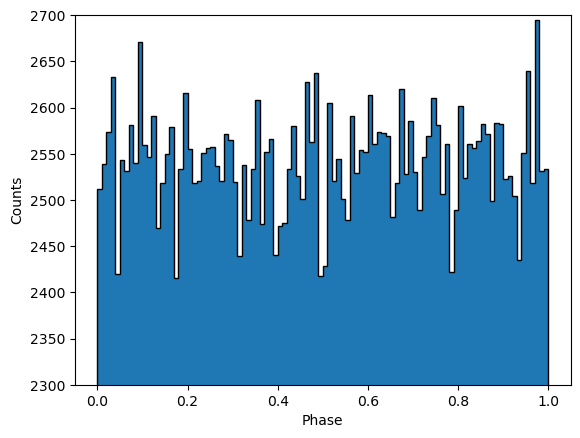

In [21]:
phases = pulsar_table.data['PHASE'] #Extract the phases
plt.hist(phases,bins=100,histtype='stepfilled',facecolor='C0', edgecolor='black') #Histogram of the phases with 100 bins
plt.ylim(2300,2700)
plt.xlabel('Phase')
plt.ylabel('Counts')

Of course we see no signal since we are using only one run. If we join the phases from several runs, a pulse could be seen.

---------

-------

## **3. Applying correction to the DL2 files (non-standard)**

### **3.1. Using the script (preferred method)**

Sometimes we are not interested in working with the DL3 files, but only on checking the overall pulsed signal. For that, the DL2 information is enough. There is a script in python to add the phase information to the DL2 files, called add_DL2_phase_table.py

This script calles, similarly to the DL3 case, to a function named DL2_calphase. But in this case, since the files need later be manipulated (cut on certain parameters), it is better to just run the script in the terminal, without worrying the internal function.

In [19]:
!add_DL2_phase_table --help

usage: add_DL2_phase_table [-h] [--dir DIRECTORY] [--in-file IN_FILE]
                           [--ephem EPHEM] [--pickle PICKLE]
                           [--run-number RUN] [--include-theta]
                           [--interpolation] [--number-interpolation NINTERP]

optional arguments:
  -h, --help            show this help message and exit
  --dir DIRECTORY, -d DIRECTORY
                        Directory where to find the standard DL3 files (one by
                        one)
  --in-file IN_FILE, -f IN_FILE
                        DL3 file to process (if want to analyze only one file)
  --ephem EPHEM, -ephem EPHEM
                        Path to the ephemeris file (.par or .gro)
  --pickle PICKLE, -pickle PICKLE
                        True if pickle, False otherwise
  --run-number RUN, -r RUN
                        Run number to process (only if --dir is given)
  --include-theta, -t   True if want to add the source position and theta2
                        values on the DL

As in the previous case, we need basically two arguments: --in-file, --ephem. An extra flag, called --include-theta can also be added to compute the theta2 values in the DL2 source-independent files as well.

In [23]:
dl2_file = '/fefs/aswg/workspace/analysis-school-2024/pulsar/Notebook1/Geminga/DL2/dl2_LST-1.Run11533.h5'

The DL2 files will be modified to include a new table with the phase information, in the DL2 file. If possible make a copy of the file in your own workspace and work with that without modifying the original file. Later you can remove it to save space.

In [24]:
!cp $dl2_file $workspace_dir

In [25]:
dl2_copied_file = workspace_dir + 'dl2_LST-1.Run11533.h5'

We can now execute the script (**WARNING: it will take some hours to finish!!!**)

In [8]:
start_time = time.time()
!add_DL2_phase_table --in-file=$dl2_copied_file --ephem=$ephem_file 
print(" Time of execution: %s seconds -" % (time.time() - start_time))

2024-01-31 10:31:24 INFO   [ptiming_ana.cphase.pulsarphase_cal] Input file:/fefs/aswg/workspace/alvaro.mas/data/LST-school-2024/dl2_LST-1.Run11533.h5
Adding MJD time
2024-01-31 10:31:48 INFO   [ptiming_ana.cphase.pulsarphase_cal] Creating .tim file
2024-01-31 10:32:01 INFO   [ptiming_ana.cphase.pulsarphase_cal] Setting the .par file
2024-01-31 10:32:01 INFO   [ptiming_ana.cphase.pulsarphase_cal] creating TOA list
2024-01-31 10:32:01.532 | DEBUG    | pint.toa:get_TOAs:193 - Using EPHEM = DE421 from the given model
2024-01-31 10:32:01.532 | DEBUG    | pint.toa:get_TOAs:209 - Using CLOCK = BIPM2021 from the given model
2024-01-31 11:19:45.979 | DEBUG    | pint.toa:__init__:1350 - No pulse number flags found in the TOAs
2024-01-31 11:20:02.811 | DEBUG    | pint.toa:apply_clock_corrections:2192 - Applying clock corrections (include_gps = True, include_bipm = True)
2024-01-31 11:27:55.111 | INFO     | pint.observatory:gps_correction:209 - Applying GPS to UTC clock correction (~few nanosecond

As you see this process with the DL2 files (not cut) is extremely long (~3 hours). If the period of the pulsar is not too high we can execute an interpolation method to make it faster (at the expense of losing some precision). 

**This interpolation method is also available in the DL3 pulsar script, but one needs to be careful of going out of the microsecond precision needed for the pulsar analysis.**

There is a copy of the processed file in the exercise directory:

In [2]:
!ls /fefs/aswg/workspace/analysis-school-2024/pulsar/Notebook1/Geminga/DL2/

dl2_LST-1.Run11533.h5	       dl2_LST-1.Run11533_pulsar.h5
dl2_LST-1.Run11533_int1000.h5


### **3.3 Exploring DL2 phase tables**

We can read the DL2 with pandas. We read the 'phase_info' table where the new information is added. The rest of the tables are unaltered.

In [5]:
dl2_pulsar_file = '/fefs/aswg/workspace/analysis-school-2024/pulsar/Notebook1/Geminga/DL2/dl2_LST-1.Run11533_pulsar.h5'
df_dl2_pulsar = pd.read_hdf(dl2_pulsar_file,key='phase_info')
df_dl2_params = pd.read_hdf(dl2_pulsar_file,key=dl2_params_lstcam_key)

Let's see how the phase table looks like:

In [6]:
df_dl2_pulsar

,obs_id,event_id,mjd_barycenter_time,pulsar_phase
0,11533,1,59934.136595,0.160237
1,11533,3,59934.136595,0.163045
2,11533,5,59934.136595,0.163530
3,11533,6,59934.136595,0.164630
4,11533,7,59934.136595,0.168016
...,...,...,...,...
5647884,11533,8758426,59934.150362,-0.189520
5647885,11533,8758427,59934.150362,-0.187065
5647886,11533,8758429,59934.150362,-0.185887
5647887,11533,8758431,59934.150362,-0.184599


And we can check the parameters table that is not modified:

In [7]:
df_dl2_params

,obs_id,event_id,intensity,log_intensity,x,y,r,phi,length,length_uncertainty,...,wl,tel_id,tel_pos_x,tel_pos_y,tel_pos_z,trigger_type,ucts_trigger_type,trigger_time,event_type,delta_t
0,11533,1,6887.765885,3.838078,-0.023592,-0.040065,0.046495,-2.102969,1.140385,0.006986,...,0.961383,1,50.0,50.0,16.0,1,1,1.671592e+09,32,0.000000
1,11533,3,882.620359,2.945774,0.505465,-0.182184,0.537295,-0.345934,0.377341,0.004926,...,0.257713,1,50.0,50.0,16.0,1,1,1.671592e+09,32,0.000385
2,11533,5,359.850204,2.556122,0.826322,-0.269081,0.869030,-0.314808,0.317453,0.008805,...,0.307294,1,50.0,50.0,16.0,1,1,1.671592e+09,32,0.000011
3,11533,6,109.913734,2.041052,0.476301,-0.960545,1.072152,-1.110462,0.083918,0.004841,...,0.695403,1,50.0,50.0,16.0,1,1,1.671592e+09,32,0.000261
4,11533,7,51.621868,1.712834,-0.221081,1.062173,1.084937,1.776006,0.095591,0.006213,...,0.309557,1,50.0,50.0,16.0,1,1,1.671592e+09,32,0.000803
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5647884,11533,8758426,126.651869,2.102612,0.042621,0.649327,0.650724,1.505252,0.478052,0.005994,...,0.103647,1,50.0,50.0,16.0,1,1,1.671593e+09,32,0.000039
5647885,11533,8758427,214.699729,2.331831,0.296062,0.690598,0.751384,1.165793,0.112435,0.004647,...,0.545687,1,50.0,50.0,16.0,1,1,1.671593e+09,32,0.000582
5647886,11533,8758429,50.552269,1.703741,-0.186737,-0.492944,0.527129,-1.932911,0.067482,0.005768,...,0.529522,1,50.0,50.0,16.0,1,1,1.671593e+09,32,0.000102
5647887,11533,8758431,68.456488,1.835415,0.740914,-0.788364,1.081883,-0.816416,0.098104,0.005820,...,0.421879,1,50.0,50.0,16.0,1,1,1.671593e+09,32,0.000279


As for the DL3 case, now we can draw a phaseogram by doing an histogram of the phases

Text(0, 0.5, 'Counts')

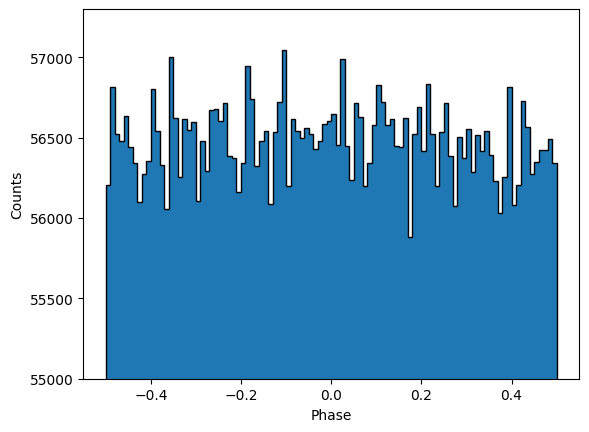

In [8]:
import matplotlib.pyplot as plt
phases_dl2 = df_dl2_pulsar['pulsar_phase']  #Extract the phases
plt.hist(phases_dl2,bins=100,histtype='stepfilled',facecolor='C0', edgecolor='black') #Histogram of the phases with 100 bins
plt.ylim(55000,57300)
plt.xlabel('Phase')
plt.ylabel('Counts')

Of course this phaseogram is meaningless since we did not apply any cut on gammaness/alpha/theta (and only one run is analyzed). If we sum all the runs and do some overall cuts on the sample we could be able to see pulses in the data.

### **3.4. Interpolation method**

To execute the script using interpolation we need to include the --interpolation flag in the add_DL3_phase_table or add_DL2_phase_table. In addition, we need to give the number of events between interpolating points (by default, it is set to 1000). If one sets a high number the execution is faster, but more precision is lost (sometimes producing non-usable values). 

Let's execute for n=1000

In [97]:
start_time = time.time()
!add_DL2_phase_table --in-file=$dl2_copied_file --ephem=$ephem_file --interpolation --number-interpolation 1000
print(" Time of execution: %s seconds -" % (time.time() - start_time))

2024-01-29 15:20:01 INFO   [ptiming_ana.cphase.pulsarphase_cal] Input file:/fefs/aswg/workspace/analysis-school-2024/pulsar/Notebook1/Geminga/DL2/dl2_LST-1.Run11533_int1000.h5
Adding MJD time
2024-01-29 15:20:11 INFO   [ptiming_ana.cphase.pulsarphase_cal] Interpolating...
2024-01-29 15:20:11 INFO   [ptiming_ana.cphase.pulsarphase_cal] Creating .tim file
2024-01-29 15:20:11 INFO   [ptiming_ana.cphase.pulsarphase_cal] Setting the .par file
2024-01-29 15:20:11 INFO   [ptiming_ana.cphase.pulsarphase_cal] creating TOA list
2024-01-29 15:20:11.985 | DEBUG    | pint.toa:get_TOAs:193 - Using EPHEM = DE421 from the given model
2024-01-29 15:20:11.985 | DEBUG    | pint.toa:get_TOAs:209 - Using CLOCK = BIPM2021 from the given model
2024-01-29 15:20:14.814 | DEBUG    | pint.toa:__init__:1350 - No pulse number flags found in the TOAs
2024-01-29 15:20:14.828 | DEBUG    | pint.toa:apply_clock_corrections:2192 - Applying clock corrections (include_gps = True, include_bipm = True)
2024-01-29 15:20:15.3

Only 50 seconds to execute!! We reduced the time by more than 99%!! Now let's compare the results

In [10]:
df_dl2_pulsar_int = pd.read_hdf(dl2_copied_file,key='phase_info')
phases_dl2_int = df_dl2_pulsar_int['pulsar_phase']

Mean value of the difference in phase:0.00
Std value of the difference in phase:0.00


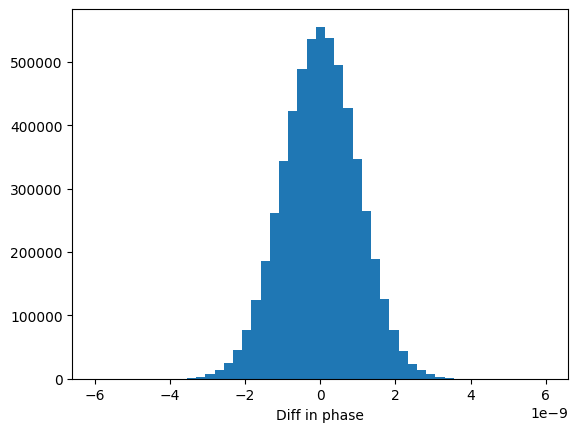

In [15]:
diff = phases_dl2 - phases_dl2_int
plt.hist(diff,bins=np.linspace(-0.6e-8,0.6e-8))
plt.xlabel('Diff in phase')
print(f'Mean value of the difference in phase:{diff.mean():.2f}')
print(f'Std value of the difference in phase:{diff.std():.2f}')

We only lose 1e-8 precision in phase, so we cannot detect any effect in the high level analysis. The results are completely compatible!!

## **4. Exercises to practice**

1. Extract the times from the DL3 file and check explicitely that the ephemeris used are valid for that epoch. 
2. Change the fractional part of the TZRMJD parameter in the ephemeris file (**please make a copy of the .par file in your workspace**) and compute again the phases for the file (you can make a copy in your working directory to avoid overwriting). Check that the resulting phase distribution (phaseogram) and check if the phases are shifted with respect to the original one.
3. Compute the phases of the DL2 file using interpolation every 100 events, and check the time of execution and the precision lost in the phases.